### This notebook analyzes an exported WhatsApp chat history
If there is a line of system information in the text file that is not attributed to one of the chat participants (e.g. "This chat is end-to-end encrypted") check if if got properly removed by the code here in case something looks weird.

Enter the participants names and the filename below and get started.

In [1]:
# enter the chatters' names and the filename here
fullname1 = "Vivi Hazrida"
fullname2 = "Pascal Bliem"
filename = "WhatsApp Chat with Vivi Hazrida.txt"

In [2]:
# import libraries
import re
import numpy as np
import pandas as pd
# set up plotting environment
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib notebook
plt.rcParams['figure.figsize'] = [7,5]
plt.rcParams['font.size'] = 12
sns.set_style(style="darkgrid")

In [3]:
# read the chat file content
with open(filename,"r") as file:
    content = file.read()
# remove the line about end-to-end encryption
WAencr = "Messages to this chat and calls are now secured with end-to-end encryption. Tap for more info."
content = re.sub("\d{2}/\d{2}/\d{4},\s+\d\d:\d\d.+"+WAencr+"\n","",content)
# extract dates, names and text content
dates = re.findall("\d{2}/\d{2}/\d{4},\s+\d\d:\d\d",content)[0:] 
names = re.findall(fullname1+":|"+fullname2+":",content) 
names = [n[:-1] for n in names]# stripping the colon
name1 = fullname1.split()[0]# get first names
name2 = fullname2.split()[0]
texts = re.split("\d{2}/\d{2}/\d{4},\s+\d\d:\d\d",content)[1:]# 0th elements will be empty
texts = [re.sub("\n","",line) for line in texts]# remove newlines
texts = [re.sub("^ -.+: ","",line) for line in texts]# remove senders name in text content
data = np.array([dates,names,texts]).T
# check for same number of parsed units
if (len(texts)!=len(names)) or (len(texts)!=len(dates)):
    print("WARNING: unequal number of dates, sender names, and text messages parsed!\nDates: {}\nNames: {}\nTexts: {}".format(len(dates),len(names),len(texts)))
else:
    print("Successfully parsed {} chat messages".format(len(dates)))

Successfully parsed 7138 chat messages


In [4]:
# create a pandas data frame
df = pd.DataFrame(data, columns=["DateTime","Sender","Message"])
df.DateTime = df.DateTime.apply(lambda x: pd.to_datetime(x,dayfirst=True))
# agregate some data about messages and word count
for name in [name1,name2]:
    df["From"+name] = np.nan
    df.loc[df.Sender.str.match(name),"From"+name] = 1
    df["WordCount"+name] = np.nan
    df.loc[df.Sender.str.match(name),"WordCount"+name] = df.loc[df.Sender.str.match(name),"Message"].apply(lambda x: len(re.findall("[^\d\s,\.!\?:;]+",x)))
df["MessageCount"] = 1
df["WordCount"] = df["Message"].apply(lambda x: len(re.findall("[^\d\s,\.!\?:;]+",x)))
df.tail()

,DateTime,Sender,Message,FromVivi,WordCountVivi,FromPascal,WordCountPascal,MessageCount,WordCount
7133,2019-09-01 14:49:00,Vivi Hazrida,"hhe he.,kamu jarang sekali selfie",1.0,6.0,NaN,NaN,1,6
7134,2019-09-01 14:56:00,Vivi Hazrida,kamu sedang calling ?,1.0,3.0,NaN,NaN,1,3
7135,2019-09-01 14:57:00,Pascal Bliem,"Nggak, Ku di kereta sedang kembali ke pusat kota",NaN,NaN,1.0,9.0,1,9
7136,2019-09-01 14:58:00,Pascal Bliem,<Media omitted>,NaN,NaN,1.0,2.0,1,2
7137,2019-09-01 15:01:00,Vivi Hazrida,"i am scare if my tounge slip, 🐥",1.0,8.0,NaN,NaN,1,8


How many messages were sent in total by each sender?

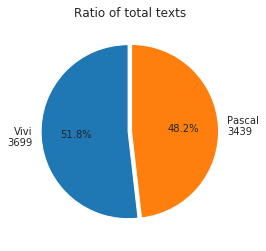

In [5]:
total_texts = [len(df[df.Sender.str.match(name1)]),len(df[df.Sender.str.match(name2)])]

fig1, ax1 = plt.subplots()
ax1 = plt.pie(total_texts,labels=["{}\n{}".format(name1,total_texts[0]),"{}\n{}".format(name2,total_texts[1])], 
              autopct='%1.1f%%',startangle=90,shadow=False,explode=[0.02,0.02])
_ = plt.gca().set_title("Ratio of total texts")
plt.savefig("RatioOfTotalTexts.png",dpi=300)

Let's have a look at the average amount of words per text

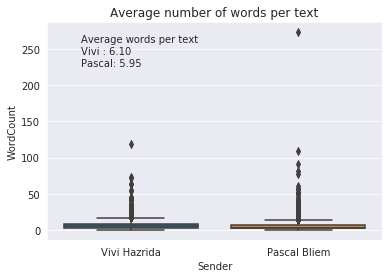

In [6]:
av_num_wrd1 = df["WordCount"+name1].mean()
av_num_wrd2 = df["WordCount"+name2].mean()
fig1, ax1 = plt.subplots()
sns.boxplot(df.Sender,df.WordCount,ax=ax1)
_ = plt.text(0.1,0.8,"Average words per text\n{} : {:.2f}\n{}: {:.2f}".format(name1,av_num_wrd1,name2,av_num_wrd2),transform=ax1.transAxes)
ax1.set_title("Average number of words per text")
plt.savefig("Averagenumberofwordspertext.png",dpi=300)


Let's look at texts per day

Comparing means with T-test yields a p-value of 61.01 %.


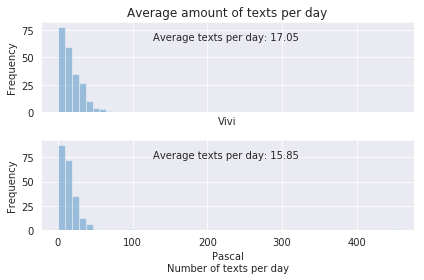

In [7]:
df_date = df.groupby(df.DateTime.dt.date).agg({"From"+name1 : ["sum"],"From"+name2 : ["sum"]})
df_date.columns = [name1,name2]
bins= np.linspace(0, int(max(df_date.max())),50)

fig, (ax1, ax2) = plt.subplots(nrows=2,ncols=1,sharex=True)
sns.distplot(df_date[name1],bins=bins,kde=False,ax=ax1)
sns.distplot(df_date[name2],bins=bins,kde=False,ax=ax2)
ax1.set_ylabel("Frequency")
ax1.text(0.3,0.8,"Average texts per day: {:.2f}".format(df_date[name1].mean()),transform=ax1.transAxes)
ax2.text(0.3,0.8,"Average texts per day: {:.2f}".format(df_date[name2].mean()),transform=ax2.transAxes)
ax2.set_ylabel("Frequency")
ax2.set_xlabel(name2+"\nNumber of texts per day")
ax1.set_title("Average amount of texts per day")
plt.tight_layout()
from scipy.stats import ttest_ind
t, p = ttest_ind(df_date[name1],df_date[name2])
print("Comparing means with T-test yields a p-value of {:.2f} %.".format(p*100))
plt.savefig("AverageNumberOfTextsPerDay.png",dpi=300)

Texts according to the day of the week

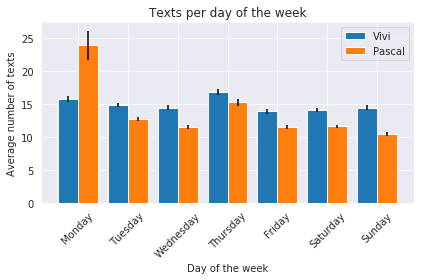

In [8]:
# calc time in weeks over the time span
numweeks = (df.DateTime.max()-df.DateTime.min()).days/7
df_day = []
for d in range(0,7):
    dayrow = []
    day = df[df.DateTime.dt.dayofweek==d].groupby(df.DateTime.dt.date).sum()
    dayrow.append(day["From"+name1].sum()/numweeks)
    dayrow.append(day["From"+name2].sum()/numweeks)
    dayrow.append(day["From"+name1].std()/numweeks)
    dayrow.append(day["From"+name2].std()/numweeks)
    df_day.append(dayrow)
df_day = np.array(df_day)
fig, (ax1) = plt.subplots(nrows=1,ncols=1,)
plt.bar(np.arange(7)-0.4,df_day[:,0],yerr=df_day[:,2],width=0.4,label=name1,align='edge')
plt.bar(np.arange(7),df_day[:,1],yerr=df_day[:,3],width=0.4,label=name2,align='edge')
plt.gca().set_xlabel("Day of the week")
plt.gca().set_ylabel("Average number of texts")
plt.gca().set_title("Texts per day of the week")
plt.gca().set_xticklabels(["","Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday",],rotation=45)
plt.legend()
plt.tight_layout()
plt.savefig("TextsPerDayOfTheWeek.png",dpi=300)


Now according to hour of the day

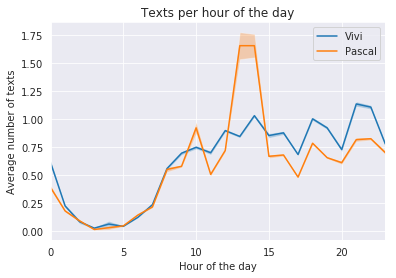

In [9]:
numdays = (df.DateTime.max()-df.DateTime.min()).days
df_hour = []
for h in range(0,24):
    hourrow = []
    hour = df[df.DateTime.dt.hour==h].groupby(df.DateTime.dt.date).sum()
    hourrow.append(hour["From"+name1].sum()/numdays)
    hourrow.append(hour["From"+name2].sum()/numdays)
    hourrow.append(hour["From"+name1].std()/numdays)
    hourrow.append(hour["From"+name2].std()/numdays)
    df_hour.append(hourrow)
df_hour = np.array(df_hour)

fig, (ax1) = plt.subplots(nrows=1,ncols=1,)
sns.lineplot(np.arange(24),df_hour[:,0],ax=ax1,label=name1)
plt.fill_between(x=np.arange(24),y1=df_hour[:,0]+df_hour[:,2],y2=df_hour[:,0]-df_hour[:,2],alpha=0.3)
sns.lineplot(np.arange(24),df_hour[:,1],ax=ax1,label=name2)
plt.fill_between(x=np.arange(24),y1=df_hour[:,1]+df_hour[:,3],y2=df_hour[:,1]-df_hour[:,3],alpha=0.3)
plt.gca().set_xlim([0,23])
plt.gca().set_xlabel("Hour of the day")
plt.gca().set_ylabel("Average number of texts")
_ = plt.gca().set_title("Texts per hour of the day")
plt.savefig("TextsPerHourOfTheDay.png",dpi=300)

Let's collect all words, emojis, and count how many media files were sent

In [10]:
words = [[],[]]
emojis = [[],[]]
media_cnt =[0,0]
# go through all texts
for i,text in df.Message.iteritems():
    # if "<Media omitted>" is found it was a send media file, just increase the media count
    if re.match("<Media omitted>",text):
        text = re.sub("<Media omitted>","",text)
        if re.match(name1,df.loc[i,"Sender"]):
            media_cnt[0] += 1
        else:
            media_cnt[1] += 1
    #split text into words    
    for word in text.split():
        # if it's an emoji, add to emoji list
        if re.match("[\u263a-\U0001f645]",word,re.UNICODE):
            if re.match(name1,df.loc[i,"Sender"]):
                emojis[0].append(word)
            else:
                emojis[1].append(word)
        # if it's a word, add to word list
        elif re.match("[^\d\s\.,;:?!\+\-\*]+",word):
            if re.match(name1,df.loc[i,"Sender"]):
                words[0].append(word)
            else:
                words[1].append(word)


Now we'll make some plots about the favorite words and emojis

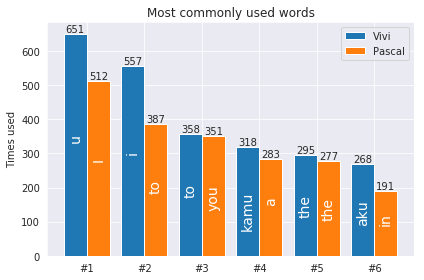

In [11]:

counts = np.concatenate(( 
         np.array(pd.Series(words[0]).value_counts().values[:6]).reshape(-1,1),
         np.array(pd.Series(words[1]).value_counts().values[:6]).reshape(-1,1)),
         axis=1)
top_words= np.concatenate(( 
         np.array(pd.Series(words[0]).value_counts().index[:6]).reshape(-1,1),
         np.array(pd.Series(words[1]).value_counts().index[:6]).reshape(-1,1)),
         axis=1)

fig, (ax1) = plt.subplots(nrows=1,ncols=1,)
bars1 = plt.bar(np.arange(6)-0.4,counts[:,0],width=0.4,label=name1,align='edge')
bars2 = plt.bar(np.arange(6),counts[:,1],width=0.4,label=name2,align='edge')

for i,bars in enumerate([bars1,bars2]):
    for j,bar in  enumerate(bars):
        height = bar.get_height()
        ax1.annotate('{}'.format(height),
                    xy=(bar.get_x() + bar.get_width() / 2, height+5),ha="center")
        ax1.annotate('{}'.format(top_words[j,i]),
                    xy=(bar.get_x() + bar.get_width() / 2, height/2),ha="center",color="w",fontsize=14,rotation=90)


plt.gca().set_xlabel("")
plt.gca().set_ylabel("Times used")
plt.gca().set_title("Most commonly used words")
plt.gca().set_xticklabels(["","#1","#2","#3","#4","#5","#6"],rotation=0)
plt.legend()
plt.tight_layout()
plt.savefig("MostCommonlyUsedWords.png",dpi=300)



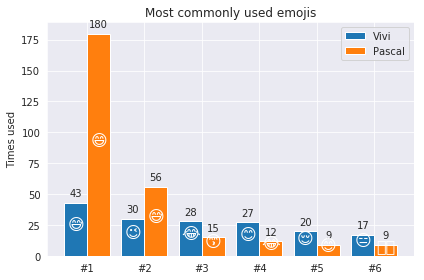

In [12]:
ecounts = np.concatenate(( 
         np.array(pd.Series(emojis[0]).value_counts().values[:6]).reshape(-1,1),
         np.array(pd.Series(emojis[1]).value_counts().values[:6]).reshape(-1,1)),
         axis=1)
top_emojis= np.concatenate(( 
         np.array(pd.Series(emojis[0]).value_counts().index[:6]).reshape(-1,1),
         np.array(pd.Series(emojis[1]).value_counts().index[:6]).reshape(-1,1)),
         axis=1)

fig, (ax1) = plt.subplots(nrows=1,ncols=1,)
bars1 = plt.bar(np.arange(6)-0.4,ecounts[:,0],width=0.4,label=name1,align='edge')
bars2 = plt.bar(np.arange(6),ecounts[:,1],width=0.4,label=name2,align='edge')

for i,bars in enumerate([bars1,bars2]):
    for j,bar in  enumerate(bars):
        height = bar.get_height()
        ax1.annotate('{}'.format(height),
                    xy=(bar.get_x() + bar.get_width() / 2, height+5),ha="center")
        ax1.annotate('{}'.format(top_emojis[j,i]),
                    xy=(bar.get_x() + bar.get_width() / 2, height/2),ha="center",color="w",fontsize=16,rotation=0)


plt.gca().set_xlabel("")
plt.gca().set_ylabel("Times used")
plt.gca().set_title("Most commonly used emojis")
plt.gca().set_xticklabels(["","#1","#2","#3","#4","#5","#6"],rotation=0)
plt.legend()
plt.tight_layout()
plt.savefig("MostCommonlyUsedEmojis.png",dpi=300)


Who send the first text of the day how often?

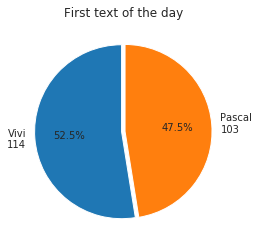

In [13]:
first_sender = []
for d in df.DateTime.dt.date.unique():
    first_sender.append(df[df.DateTime.dt.date == d].iloc[0].Sender)
first_sender = pd.Series(first_sender).value_counts().values

fig1, ax1 = plt.subplots()
ax1 = plt.pie(first_sender,labels=["{}\n{}".format(name1,first_sender[0]),"{}\n{}".format(name2,first_sender[1])], 
              autopct='%1.1f%%',startangle=90,shadow=False,explode=[0.02,0.02])
_ = plt.gca().set_title("First text of the day")

plt.savefig("FirstTextOfTheDay.png",dpi=300)


In [14]:
lookup = "kentut"
num = len(pd.Series(words[0]+words[1])[pd.Series(words[0]+words[1]).str.match(lookup,re.IGNORECASE)])
print("How often did we say {}?\n{} times".format(lookup,num))

How often did we say kentut?
7 times
